In [1]:
from FuzzyTM import FLSA_W
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
def filter_word_from_corpus(data, words):
    # Ensure words is a list, even if a single string is passed
    
    if isinstance(words, list):
    # Filter words from data
        filtered_data = [[token for token in row if token not in words] for row in data]
        
    return filtered_data

In [3]:
def train_and_evaluate_flsaW(processed_content, num_topics, num_words=20):
    """
    Trains the FLSA-W model, prints the topics and evaluation scores.
    
    Parameters:
    - processed_content (list of lists): The tokenized text data for training.
    - num_topics (int): The number of topics to generate.
    - num_words (int): The number of words per topic to display.
    
    Returns:
    - None
    """
    # Initialize the FLSA-W model
    flsaW = FLSA_W(
        input_file=processed_content,
        num_topics=num_topics,
        num_words=num_words,
    )

    # Print vocabulary size
    print(f'Vocabulary size: {flsaW.get_vocabulary_size()}')
    
    # Train the model by generating probability matrices
    pwgt, ptgd = flsaW.get_matrices()

    # Display the topics
    print("Topics:")
    for topic in flsaW.show_topics(representation='words'):
        print(topic)
    
    # Calculate and print evaluation scores
    coherence_score = flsaW.get_coherence_score()
    diversity_score = flsaW.get_diversity_score()
    interpretability_score = flsaW.get_interpretability_score()

    print(f'Coherence score: {coherence_score}')
    print(f'Diversity score: {diversity_score}')
    print(f'Interpretability score: {interpretability_score}')
    
    return flsaW



In [4]:
def compute_flsaw_coherence_values(input_data, num_topics_list, num_words):
    """
    Compute coherence scores for various number of topics for FLSA-W.

    Parameters:
    ----------
    input_data : List of input texts (processed content)
    num_topics_list : List of numbers of topics to evaluate
    num_words : Number of words to represent topics
    passes : Number of passes for model training

    Returns:
    -------
    coherence_values : Coherence values for each number of topics
    """
    coherence_values = []

    for num_topics in num_topics_list:
        flsaW = FLSA_W(input_file=input_data, num_topics=num_topics, num_words=num_words)
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()  # Get the coherence score
        coherence_values.append(coherence_score)

    return coherence_values

In [5]:
def compute_flsaw_interpretability_values(input_data, num_topics_list, num_words):
    """
    Compute interpretability scores for various number of topics for FLSA-W.

    Parameters:
    ----------
    input_data : List of input texts (processed content)
    num_topics_list : List of numbers of topics to evaluate
    num_words : Number of words to represent topics

    Returns:
    -------
    interpretability_values : Interpretability values for each number of topics
    """
    interpretability_values = []

    for num_topics in num_topics_list:
        flsaW = FLSA_W(input_file=input_data, num_topics=num_topics, num_words=num_words)
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        interpretability_score = flsaW.get_interpretability_score()  # Get the interpretability score
        interpretability_values.append(interpretability_score)

    return interpretability_values


In [6]:
def filter_and_compare_coherence(word_list, max_iterations, file_path, num_topics):
    # Initialize an empty list to store results
    results = []
    # Load the data
    processed_df =  pd.read_csv(file_path)

    # Extract processed content as a list of lists (tokenized documents)
    processed_content = [content.split() for content in processed_df['processed_content']]
    
    for word in word_list[:max_iterations]:  # Limit iterations to max_iterations
        # Filter the current word from the processed content
        filtered_content = filter_word_from_corpus(processed_content, [word])
        
        # Train the FLSA-W model
        flsaW = FLSA_W(input_file=filtered_content, num_topics=num_topics, num_words=10)
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        
        # Get the coherence score
        coherence_score = flsaW.get_coherence_score()
        
        # Store the word and its corresponding coherence score
        results.append((word, coherence_score))
        
        # Print the topics and coherence score for this iteration
        print(f"Removed word: {word}")
        print(f"Coherence score: {coherence_score}\n")
        
    # Return the results for further analysis if needed
    return results

In [7]:
def find_most_common_words(file_path, top_n=10):
    # Load the processed data
    processed_df = pd.read_csv(file_path)
    
    # Extract processed content as a list of lists (tokenized documents)
    processed_content = [content.split() for content in processed_df['processed_content']]
    
    # Flatten the list of documents into a single list of words
    all_words = [word for doc in processed_content for word in doc]
    
    # Count the frequency of each word
    word_freq = Counter(all_words)
    
    # Get the most common words
    most_common = word_freq.most_common(top_n)
    
    return most_common

In [8]:
def find_most_common_words_v2(file_path, top_n=10, min_doc_freq=0.7):
    # Load processed data
    processed_df = pd.read_csv(file_path)
    processed_content = [content.split() for content in processed_df['processed_content']]
    
    # Flatten words and calculate frequencies
    all_words = [word for doc in processed_content for word in doc]
    word_freq = Counter(all_words)
    
    # Find words that appear in more than `min_doc_freq` fraction of documents
    doc_count = len(processed_content)
    frequent_words = [word for word, freq in word_freq.items() if freq / doc_count > min_doc_freq]
    
    # Exclude those frequent words from top_n most common list
    refined_common = [word for word, _ in word_freq.most_common(top_n + len(frequent_words)) if word not in frequent_words]
    
    # Return the refined list of most common words
    return refined_common[:top_n]


In [9]:
# Updated function to filter and retrain on batches of words
def batch_filter_and_retrain(word_batches, file_path, num_topics, num_words):
    # Load and preprocess data
    processed_df = pd.read_csv(file_path)
    processed_content = [content.split() for content in processed_df['processed_content']]
    
    results = []
    for i, word_batch in enumerate(word_batches):
        # Apply filtering in batches
        filtered_content = filter_word_from_corpus(processed_content, word_batch)
        
        # Retrain the model
        flsaW = FLSA_W(input_file=filtered_content, num_topics=num_topics, num_words=num_words)
        pwgt, ptgd = flsaW.get_matrices()
        coherence_score = flsaW.get_coherence_score()
        interpretability_score = flsaW.get_interpretability_score()
        diversity_score = flsaW.get_diversity_score()
        
        results.append((word_batch, coherence_score,interpretability_score,diversity_score))
        print(f"Batch {i+1}, Words removed: {word_batch}")
        print(f"Coherence score: {coherence_score}\n")
        print(f"Interpretability score: {interpretability_score}\n")
        print(f"Diversity score: {diversity_score}\n")
        
    return results

In [10]:
def batch_filter_and_retrain_with_best_model(word_batches, file_path, num_topics, num_words):
    processed_df = pd.read_csv(file_path)
    processed_content = [content.split() for content in processed_df['processed_content']]
    
    best_model = None
    best_coherence_score = -float('inf')
    best_batch = None
    results = []

    for i, word_batch in enumerate(word_batches):
        filtered_content = filter_word_from_corpus(processed_content, word_batch)
        flsaW = FLSA_W(input_file=filtered_content, num_topics=num_topics, num_words=num_words)
        pwgt, ptgd = flsaW.get_matrices()  # Train the model
        coherence_score = flsaW.get_coherence_score()
        interpretability_score = flsaW.get_interpretability_score()
        diversity_score = flsaW.get_diversity_score()

        results.append((word_batch, coherence_score, interpretability_score, diversity_score))
        
        # Track best model based on coherence score
        if coherence_score > best_coherence_score:
            best_coherence_score = coherence_score
            best_model = flsaW
            best_batch = word_batch

    # Output results for each batch
    for batch, coh_score, int_score, div_score in results:
        print(f"Removed words: {batch}, Coherence score: {coh_score}, Diversity score: {div_score}, Interpretability score: {int_score}")
    
    print(f"\nBest batch removed: {best_batch} with Coherence score: {best_coherence_score}")
    return best_model

In [11]:
def filter_extreme_frequencies(data, percent=0):
    """
    Removes the most and least frequent words based on the specified percentage.

    Parameters:
    data (list of lists): Tokenized text data, where each sublist is a document.
    percent (float): Percentage of the most and least frequent words to exclude.

    Returns:
    list of lists: Modified data with top and bottom 'percent' words removed.
    """
    if percent <= 0 or percent > 50:
        raise ValueError("Percentage must be greater than 0 and no more than 50.")

    # Flatten the list to obtain word frequencies
    words_flattened = [word for doc in data for word in doc]
    frequency_counts = Counter(words_flattened)

    # Calculate how many words to exclude at each end
    exclusion_count = int(percent / 100 * len(frequency_counts))

    # Identify the words to remove: high-frequency and low-frequency words
    high_frequency_words = set([word for word, _ in frequency_counts.most_common(exclusion_count)])
    low_frequency_words = set([word for word, _ in frequency_counts.most_common()[-exclusion_count:]])

    # Combine words to be excluded
    exclusion_words = high_frequency_words | low_frequency_words

    # Filter out the identified words from the original data
    cleaned_data = [[word for word in doc if word not in exclusion_words] for doc in data]

    # Remove any empty documents resulting from the filtering process
    cleaned_data = [doc for doc in cleaned_data if doc]

    return cleaned_data


In [7]:

# Load the data
processed_df = pd.read_csv('../data/flsaw_processed_content.csv')

# Extract processed content as a list of lists (tokenized documents)
processed_content = [content.split() for content in processed_df['processed_content']]

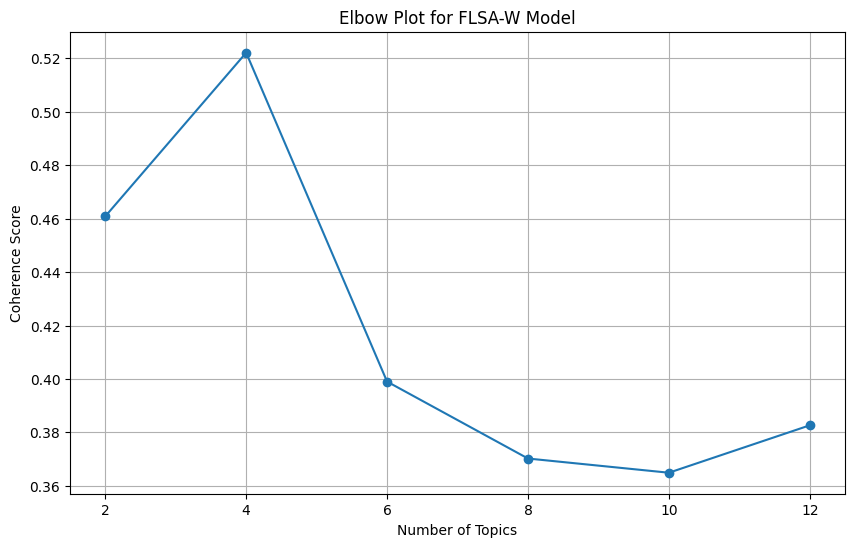

In [7]:
# Define the range of topics to evaluate
num_topics_list = range(2, 14, 2) 
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

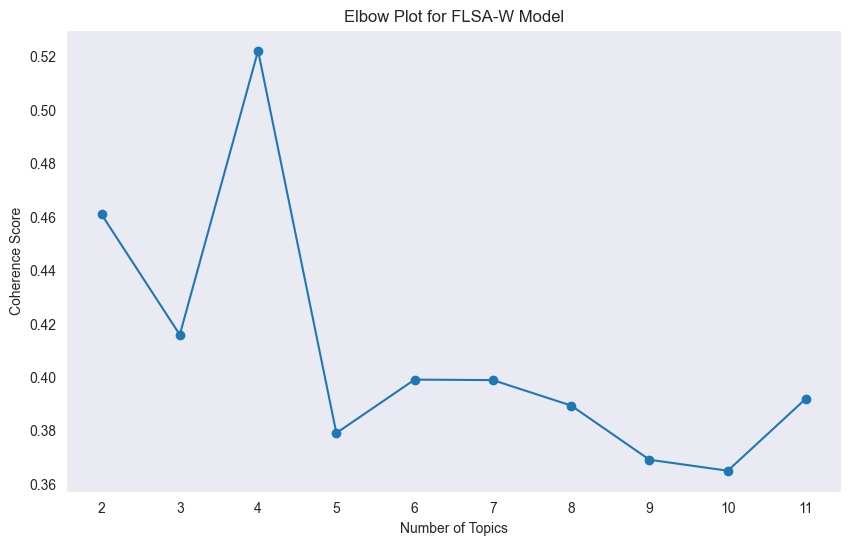

In [9]:
# Define the range of topics to evaluate
num_topics_list = range(2, 12, 1) 
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

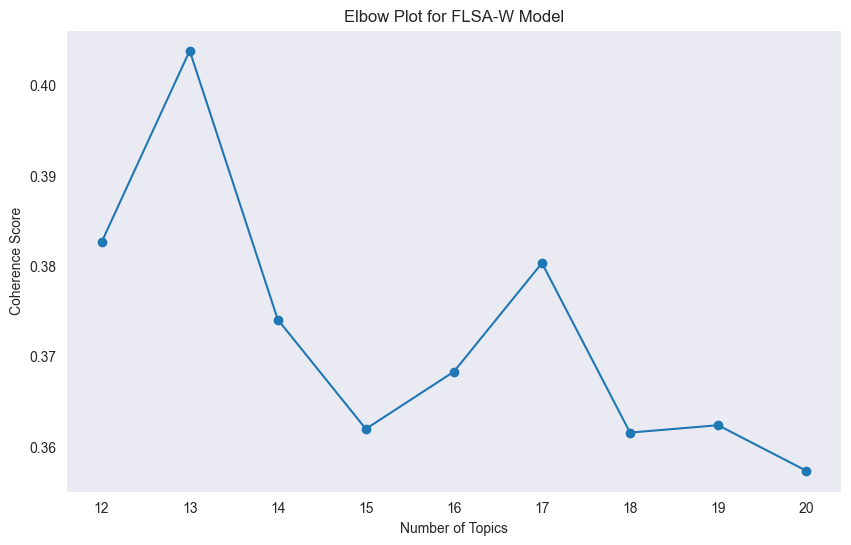

In [10]:
# Define the range of topics to evaluate
num_topics_list = range(12, 21, 1) 
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

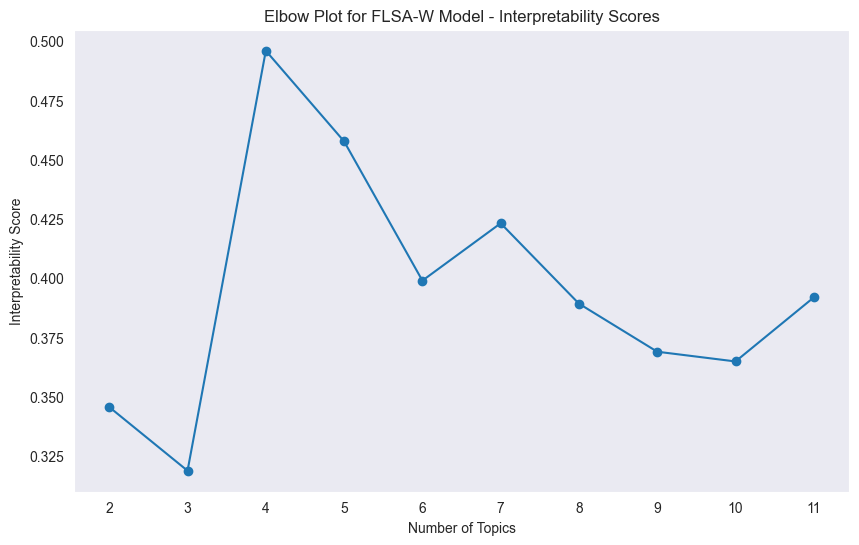

In [12]:
# Define the range of topics to evaluate
num_topics_list = range(2, 12, 1) 
num_words = 10  # Number of words to display per topic

# Compute interpretability values for the defined number of topics
interpretability_scores = compute_flsaw_interpretability_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, interpretability_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model - Interpretability Scores')
plt.xlabel('Number of Topics')
plt.ylabel('Interpretability Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

# Although 4 topics have a higher interpretability score, in reality it is really hard for any human to understand the topics. They are very general and also might be irrelevant as well (Book, evolution, science, richard) with our dataset. So this seems to be an outlier than a reliable result.   

In [9]:
flsaW = FLSA_W(
input_file = processed_content,
num_topics=4,
num_words=10,
)

flsaW.get_vocabulary_size()

pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL

print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)

print(f'Coherence score: {flsaW.get_coherence_score()}')
print(f'Diversity score: {flsaW.get_diversity_score()}')
print(f'Interpretability score: {flsaW.get_interpretability_score()}')

[(0, '0.0011*"nvda" + 0.0011*"corporation" + 0.0011*"nvidia" + 0.0011*"inc" + 0.001*"nasdaq" + 0.001*"investing" + 0.001*"com" + 0.001*"shares" + 0.0009*"rank" + 0.0009*"intc"'), (1, '0.0083*"book" + 0.0071*"evolution" + 0.0071*"books" + 0.0068*"science" + 0.0067*"richard" + 0.0061*"modern" + 0.0055*"certainty" + 0.0053*"professor" + 0.0049*"mind" + 0.0041*"theory"'), (2, '0.0004*"gmt" + 0.0004*"uncover" + 0.0003*"nasdaq" + 0.0003*"ounce" + 0.0003*"esp" + 0.0003*"unchanged" + 0.0003*"philadelphia" + 0.0003*"outnumbered" + 0.0003*"brent" + 0.0003*"advancing"'), (3, '0.0002*"nasdaq" + 0.0002*"premarket" + 0.0002*"also" + 0.0002*"market" + 0.0002*"troy" + 0.0002*"company" + 0.0002*"new" + 0.0002*"stocks" + 0.0002*"one" + 0.0002*"time"')]
['nvda', 'corporation', 'nvidia', 'inc', 'nasdaq', 'investing', 'com', 'shares', 'rank', 'intc']
['book', 'evolution', 'books', 'science', 'richard', 'modern', 'certainty', 'professor', 'mind', 'theory']
['gmt', 'uncover', 'nasdaq', 'ounce', 'esp', 'uncha

In [12]:
file_path = '../data/flsaw_processed_content.csv'
top_n = 10
common_words = find_most_common_words(file_path, top_n)

# Print the most common words
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")


Most Common Words:
nasdaq: 14865
year: 13875
zacks: 11525
company: 11355
earnings: 9907
nvidia: 8932
stocks: 8380
market: 8254
quarter: 7798
growth: 7348


# It is very interesting that removing words does not improve the coherence score. More popular words like 'Year' and 'nasdaq' which seem to not play a role even significantly lower the coherence score.

In [13]:
max_iterations = len(common_words)  # Set max iterations
coherence_results = filter_and_compare_coherence(common_words, max_iterations)


best_word = max(coherence_results, key=lambda x: x[1])
print(f"Best word to remove for coherence improvement: {best_word[0]} with coherence score: {best_word[1]}")

Removed word: ('nasdaq', 14865)
Coherence score: 0.36057155035201327
Removed word: ('year', 13875)
Coherence score: 0.36057155035201316
Removed word: ('zacks', 11525)
Coherence score: 0.5221179806808217
Removed word: ('company', 11355)
Coherence score: 0.5221179806808217
Removed word: ('earnings', 9907)
Coherence score: 0.5221179806808218
Removed word: ('nvidia', 8932)
Coherence score: 0.5221179806808218
Removed word: ('stocks', 8380)
Coherence score: 0.5221179806808217
Removed word: ('market', 8254)
Coherence score: 0.5221179806808218
Removed word: ('quarter', 7798)
Coherence score: 0.5221179806808217
Removed word: ('growth', 7348)
Coherence score: 0.5221179806808217

Best word to remove for coherence improvement: ('earnings', 9907) with coherence score: 0.5221179806808218


# We are going to introduce stemming and lemmatization and see how it affects the coherence score.

In [29]:
file_path = '../data/flsaw_processed_content_lemmatised.csv'
top_n = 10
common_words = find_most_common_words(file_path, top_n)

# Print the most common words
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Most Common Words:
year: 16086
company: 15457
stock: 15450
nasdaq: 14865
zacks: 11525
market: 10486
earnings: 9907
nvidia: 8932
quarter: 8711
share: 8211


# Lemmatization does not improve the model but performs better than stemming.

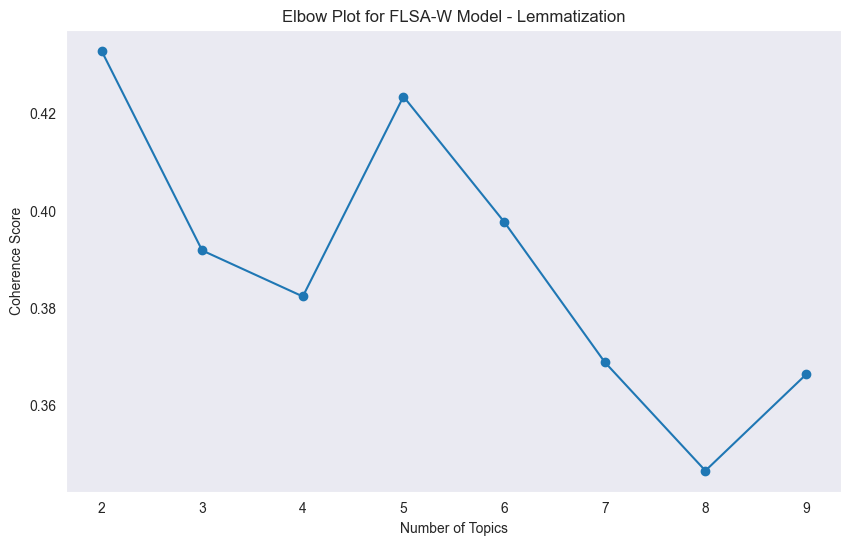

In [30]:
# Load the data
processed_df =  pd.read_csv(file_path)

# Extract processed content as a list of lists (tokenized documents)
processed_content = [content.split() for content in processed_df['processed_content']]

# Define the range of topics to evaluate
num_topics_list = range(2, 10, 1)  
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model - Lemmatization')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

In [37]:
max_iterations = len(common_words)  # Set max iterations
num_topics = 5
coherence_results = filter_and_compare_coherence(common_words, max_iterations,file_path,num_topics)


best_word = max(coherence_results, key=lambda x: x[1])
print(f"Best word to remove for coherence improvement: {best_word[0]} with coherence score: {best_word[1]}")

Removed word: ('year', 16086)
Coherence score: 0.3792432625092587
Removed word: ('compani', 15457)
Coherence score: 0.37924326250925866
Removed word: ('stock', 15457)
Coherence score: 0.37924326250925866
Removed word: ('nasdaq', 14865)
Coherence score: 0.3792432625092587
Removed word: ('zack', 11545)
Coherence score: 0.3792432625092587
Removed word: ('market', 10766)
Coherence score: 0.37924326250925877
Removed word: ('earn', 10136)
Coherence score: 0.3792432625092587
Removed word: ('nvidia', 8932)
Coherence score: 0.37924326250925866
Removed word: ('quarter', 8711)
Coherence score: 0.37924326250925877
Removed word: ('share', 8360)
Coherence score: 0.3792432625092587

Best word to remove for coherence improvement: ('market', 10766) with coherence score: 0.37924326250925877


In [17]:
max_iterations = len(common_words)  # Set max iterations
num_topics = 4
coherence_results = filter_and_compare_coherence(common_words, max_iterations,file_path,num_topics)


best_word = max(coherence_results, key=lambda x: x[1])
print(f"Best word to remove for coherence improvement: {best_word[0]} with coherence score: {best_word[1]}")

Removed word: ('year', 16086)
Coherence score: 0.38236900102203353
Removed word: ('company', 15457)
Coherence score: 0.3823690010220334
Removed word: ('stock', 15450)
Coherence score: 0.38236900102203353
Removed word: ('nasdaq', 14865)
Coherence score: 0.5125391347487183
Removed word: ('zacks', 11525)
Coherence score: 0.3823690010220334
Removed word: ('market', 10486)
Coherence score: 0.5125391347487183
Removed word: ('earnings', 9907)
Coherence score: 0.5125391347487183
Removed word: ('nvidia', 8932)
Coherence score: 0.5125391347487183
Removed word: ('quarter', 8711)
Coherence score: 0.3823690010220335
Removed word: ('share', 8211)
Coherence score: 0.5125391347487183

Best word to remove for coherence improvement: ('nasdaq', 14865) with coherence score: 0.5125391347487183


In [31]:
file_path = '../data/flsaw_processed_content_stemming.csv'
top_n = 10
common_words = find_most_common_words(file_path, top_n)

# Print the most common words
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Most Common Words:
year: 16086
compani: 15457
stock: 15457
nasdaq: 14865
zack: 11545
market: 10766
earn: 10136
nvidia: 8932
quarter: 8711
share: 8360


# Stemming yields no improvement for the coherence score and has subpar perfomance compared to lemmatization. So it is time to change approach. 

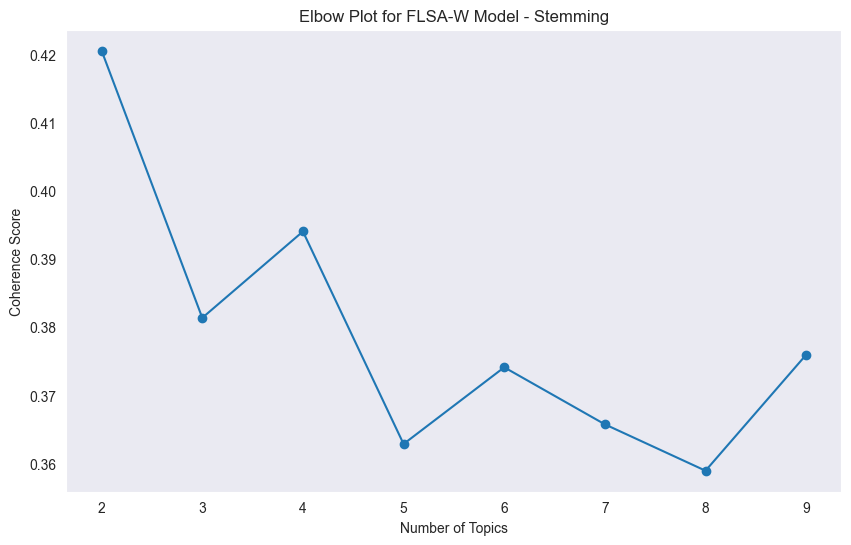

In [32]:
# Load the data
processed_df =  pd.read_csv(file_path)

# Extract processed content as a list of lists (tokenized documents)
processed_content = [content.split() for content in processed_df['processed_content']]

# Define the range of topics to evaluate
num_topics_list = range(2, 10, 1) 
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Elbow Plot for FLSA-W Model - Stemming')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid()
plt.show()

In [19]:
max_iterations = len(common_words)  # Set max iterations
coherence_results = filter_and_compare_coherence(common_words, max_iterations,file_path)


best_word = max(coherence_results, key=lambda x: x[1])
print(f"Best word to remove for coherence improvement: {best_word[0]} with coherence score: {best_word[1]}")

Removed word: ('year', 16086)
Coherence score: 0.3940304687740894
Removed word: ('compani', 15457)
Coherence score: 0.3940304687740894
Removed word: ('stock', 15457)
Coherence score: 0.3940304687740894
Removed word: ('nasdaq', 14865)
Coherence score: 0.3940304687740894
Removed word: ('zack', 11545)
Coherence score: 0.3940304687740894
Removed word: ('market', 10766)
Coherence score: 0.3940304687740894
Removed word: ('earn', 10136)
Coherence score: 0.3940304687740894
Removed word: ('nvidia', 8932)
Coherence score: 0.39403046877408937
Removed word: ('quarter', 8711)
Coherence score: 0.3940304687740894
Removed word: ('share', 8360)
Coherence score: 0.3940304687740894

Best word to remove for coherence improvement: ('year', 16086) with coherence score: 0.3940304687740894


# Now I am following the paper recommendation for FLSA-W because it seems that the approach above is not correct. So I am going to iterate the same steps in a different space of topics.

In [ ]:

# Load the data
processed_df = pd.read_csv('../data/flsaw_processed_content.csv')

# Extract processed content as a list of lists (tokenized documents)
processed_content = [content.split() for content in processed_df['processed_content']]

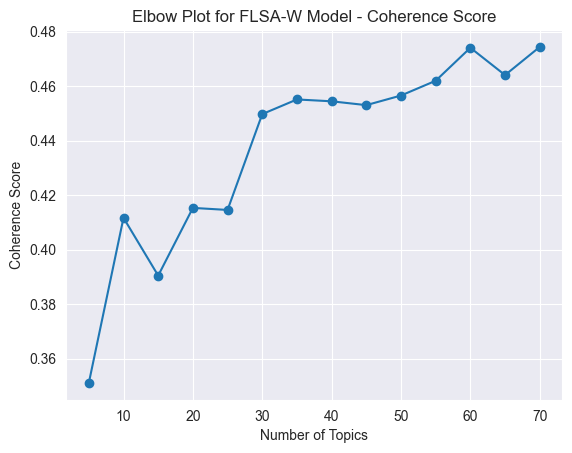

In [8]:


# Define topic numbers to test
num_topics_list = list(range(5, 75, 5))  # Range based on recommendations in the paper
num_words = 20  # Based on assignment and paper's suggestion for topic interpretability

# Compute coherence values for the topic range
coherence_values = compute_flsaw_coherence_values(input_data=processed_content, num_topics_list=num_topics_list, num_words=num_words)

# Plot the elbow plot
plt.plot(num_topics_list, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Elbow Plot for FLSA-W Model - Coherence Score")
plt.show()


In [17]:
file_path = '../data/flsaw_processed_content.csv'
num_topics = 4  # Adjust based on initial model findings or elbow plot
num_words = 20   # Number of words per topic

# Find the top common words to remove
most_common_words = find_most_common_words_v2(file_path, top_n=20)

# Define batches (e.g., in groups of 5 words for testing)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Use batch_filter_and_retrain function
results = batch_filter_and_retrain(word_batches, file_path, num_topics, num_words)

# Review results
for batch, score in results:
    print(f"Removed words: {batch}, Coherence score: {score}")

Batch 1, Words removed: ['q', 'sector', 'long', 'past', 'since']
Coherence score: 0.34160094809033015
Batch 2, Words removed: ['reported', 'term', 'next', 'estimates', 'trading']
Coherence score: 0.41980536554164516
Batch 3, Words removed: ['would', 'markets', 'demand', 'years', 'based']
Coherence score: 0.34136836121819536
Batch 4, Words removed: ['us', 'current', 'average', 'performance', 'fiscal']
Coherence score: 0.4197204287172792

Removed words: ['q', 'sector', 'long', 'past', 'since'], Coherence score: 0.34160094809033015
Removed words: ['reported', 'term', 'next', 'estimates', 'trading'], Coherence score: 0.41980536554164516
Removed words: ['would', 'markets', 'demand', 'years', 'based'], Coherence score: 0.34136836121819536
Removed words: ['us', 'current', 'average', 'performance', 'fiscal'], Coherence score: 0.4197204287172792


In [18]:
file_path = '../data/flsaw_processed_content.csv'
num_topics = 8  # Adjust based on initial model findings or elbow plot
num_words = 20   # Number of words per topic

# Find the top common words to remove
most_common_words = find_most_common_words_v2(file_path, top_n=20)

# Define batches (e.g., in groups of 5 words for testing)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Use batch_filter_and_retrain function
results = batch_filter_and_retrain(word_batches, file_path, num_topics, num_words)

# Review results
for batch, score in results:
    print(f"Removed words: {batch}, Coherence score: {score}")

Batch 1, Words removed: ['q', 'sector', 'long', 'past', 'since']
Coherence score: 0.3897706502688051
Batch 2, Words removed: ['reported', 'term', 'next', 'estimates', 'trading']
Coherence score: 0.4095614546663702
Batch 3, Words removed: ['would', 'markets', 'demand', 'years', 'based']
Coherence score: 0.38711816357926354
Batch 4, Words removed: ['us', 'current', 'average', 'performance', 'fiscal']
Coherence score: 0.40876955824584016

Removed words: ['q', 'sector', 'long', 'past', 'since'], Coherence score: 0.3897706502688051
Removed words: ['reported', 'term', 'next', 'estimates', 'trading'], Coherence score: 0.4095614546663702
Removed words: ['would', 'markets', 'demand', 'years', 'based'], Coherence score: 0.38711816357926354
Removed words: ['us', 'current', 'average', 'performance', 'fiscal'], Coherence score: 0.40876955824584016


In [22]:
# Define the range of topics to evaluate
num_topics_list = [4,8]
num_words = 20  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)
print(f"Coherence score for topic{num_topics_list[0]}: {coherence_scores[0]}")
print(f"Coherence score for topic{num_topics_list[1]}: {coherence_scores[1]}")

Coherence score for topic4: 0.34133341049117316
Coherence score for topic8: 0.38483609825889487


In [23]:
# Define the range of topics to evaluate
num_topics_list = [4,8]
num_words = 10  # Number of words to display per topic

# Compute coherence values for the defined number of topics
coherence_scores = compute_flsaw_coherence_values(processed_content, num_topics_list, num_words)
print(f"Coherence score for topic{num_topics_list[0]}: {coherence_scores[0]}")
print(f"Coherence score for topic{num_topics_list[1]}: {coherence_scores[1]}")

Coherence score for topic4: 0.5221179806808218
Coherence score for topic8: 0.38927444048128135


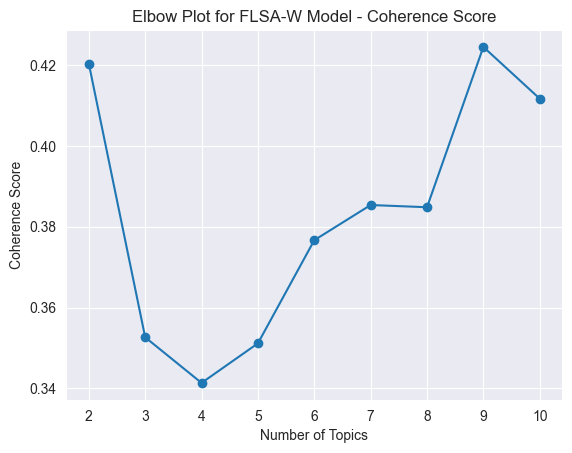

In [24]:


# Define topic numbers to test
num_topics_list = list(range(2, 11, 1))  # Range based on recommendations in the paper
num_words = 20  # Based on assignment and paper's suggestion for topic interpretability

# Compute coherence values for the topic range
coherence_values = compute_flsaw_coherence_values(input_data=processed_content, num_topics_list=num_topics_list, num_words=num_words)

# Plot the elbow plot
plt.plot(num_topics_list, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Elbow Plot for FLSA-W Model - Coherence Score")
plt.show()


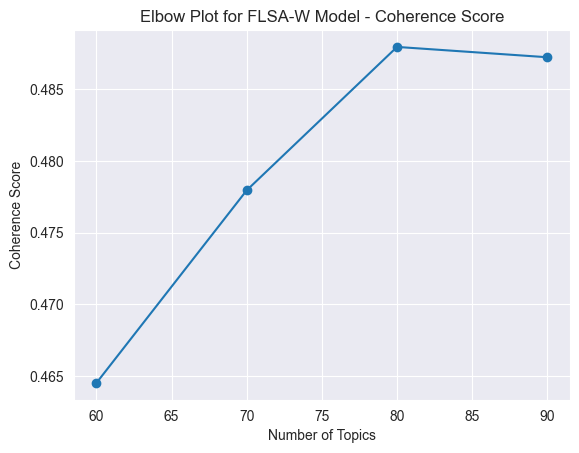

In [25]:


# Define topic numbers to test
num_topics_list = list(range(60, 100, 10))  # Range based on recommendations in the paper
num_words = 20  # Based on assignment and paper's suggestion for topic interpretability

# Compute coherence values for the topic range
coherence_values = compute_flsaw_coherence_values(input_data=processed_content, num_topics_list=num_topics_list, num_words=num_words)

# Plot the elbow plot
plt.plot(num_topics_list, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Elbow Plot for FLSA-W Model - Coherence Score")
plt.show()


In [27]:
file_path = '../data/flsaw_processed_content.csv'
num_topics = 60  # Adjust based on initial model findings or elbow plot
num_words = 20   # Number of words per topic

# Find the top common words to remove
most_common_words = find_most_common_words_v2(file_path, top_n=20)

# Define batches (e.g., in groups of 5 words for testing)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Use batch_filter_and_retrain function
results = batch_filter_and_retrain(word_batches, file_path, num_topics, num_words)

# Review results
for batch, coh_score, int_score, div_score in results:
    print(f"Removed words: {batch}, Coherence score: {coh_score}, Diversity score: {div_score}, Interpretability score: {int_score}")

Batch 1, Words removed: ['q', 'sector', 'long', 'past', 'since']
Coherence score: 0.4731269810163853

Interpretability score: 0.47194416356384433

Diversity score: 0.9975
Batch 2, Words removed: ['reported', 'term', 'next', 'estimates', 'trading']
Coherence score: 0.48051894516253074

Interpretability score: 0.47851678289102023

Diversity score: 0.9958333333333333
Batch 3, Words removed: ['would', 'markets', 'demand', 'years', 'based']
Coherence score: 0.4704879349537183

Interpretability score: 0.4697037883954621

Diversity score: 0.9983333333333333
Batch 4, Words removed: ['us', 'current', 'average', 'performance', 'fiscal']
Coherence score: 0.46773757131315935

Interpretability score: 0.46617844607544884

Diversity score: 0.9966666666666667

Removed words: ['q', 'sector', 'long', 'past', 'since'], Coherence score: 0.4731269810163853, Interpretability score: 0.9975, Interpretability score: 0.47194416356384433
Removed words: ['reported', 'term', 'next', 'estimates', 'trading'], Cohere

In [13]:
# Usage
file_path = '../data/flsaw_processed_content.csv'
num_topics = 60
num_words = 20

# Find most common words and create batches
most_common_words = find_most_common_words_v2(file_path, top_n=10)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Get the best model after filtering
best_model = batch_filter_and_retrain_with_best_model(word_batches, file_path, num_topics, num_words)




Removed words: ['q', 'sector', 'long', 'past', 'since'], Coherence score: 0.47768729015085554, Diversity score: 0.9983333333333333, Interpretability score: 0.4768911446672708
Removed words: ['reported', 'term', 'next', 'estimates', 'trading'], Coherence score: 0.4769299667333875, Diversity score: 0.9983333333333333, Interpretability score: 0.4761350834554985

Best batch removed: ['q', 'sector', 'long', 'past', 'since'] with Coherence score: 0.47768729015085554


AttributeError: 'FLSA_W' object has no attribute 'get_topics'

# The topics seem to mix scientific, philosophical, and financial jargon, which creates noise instead of a focused subject matter. It seems appropriate to lower the number of topics. 

In [16]:
for topics in best_model.show_topics():
    print(topics)

(0, '0.0016*"chipsets" + 0.0015*"esports" + 0.0015*"instrumental" + 0.0014*"smh" + 0.0013*"demanding" + 0.0013*"laboratories" + 0.0013*"premarket" + 0.0013*"insane" + 0.0013*"aaa" + 0.0013*"sa" + 0.0013*"calculating" + 0.0013*"functionalities" + 0.0013*"visiting" + 0.0013*"wheels" + 0.0012*"blackrock" + 0.0012*"winds" + 0.0012*"blackberry" + 0.0012*"xrx" + 0.0012*"garden" + 0.0012*"regained"')
(1, '0.0135*"thomas" + 0.0128*"entrepreneurs" + 0.0119*"unpredictable" + 0.0114*"controversy" + 0.0108*"discussing" + 0.0106*"newspaper" + 0.0089*"afford" + 0.0086*"centered" + 0.008*"teach" + 0.0068*"roundup" + 0.0067*"knowing" + 0.0062*"thrives" + 0.0062*"woman" + 0.0059*"perfectly" + 0.0057*"daniel" + 0.0056*"pandemic" + 0.0055*"vaccines" + 0.0054*"respiratory" + 0.0053*"dig" + 0.0053*"viruses"')
(2, '0.0066*"lrcx" + 0.0059*"skyrocketing" + 0.0058*"info" + 0.0056*"editor" + 0.0054*"referendums" + 0.0053*"frame" + 0.0053*"fund" + 0.0052*"automation" + 0.005*"revolutions" + 0.005*"pulled" + 0.00

# Lets try to lower the number to 30 topics which seems appropriate considering the elbow plot.

In [17]:
# Usage
file_path = '../data/flsaw_processed_content.csv'
num_topics = 30
num_words = 20

# Find most common words and create batches
most_common_words = find_most_common_words_v2(file_path, top_n=10)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Get the best model after filtering
best_model = batch_filter_and_retrain_with_best_model(word_batches, file_path, num_topics, num_words)


Removed words: ['q', 'sector', 'long', 'past', 'since'], Coherence score: 0.4433508195860745, Diversity score: 0.9983333333333333, Interpretability score: 0.442611901553431
Removed words: ['reported', 'term', 'next', 'estimates', 'trading'], Coherence score: 0.451226679440285, Diversity score: 0.9983333333333333, Interpretability score: 0.45047463497455115

Best batch removed: ['reported', 'term', 'next', 'estimates', 'trading'] with Coherence score: 0.451226679440285


In [18]:
for topics in best_model.show_topics():
    print(topics)

(0, '0.0087*"discussing" + 0.0084*"afford" + 0.0083*"unpredictable" + 0.0081*"thomas" + 0.0075*"roundup" + 0.007*"controversy" + 0.0069*"centered" + 0.0066*"newspaper" + 0.0066*"entrepreneurs" + 0.0065*"daniel" + 0.0062*"episode" + 0.0061*"elon" + 0.0058*"passage" + 0.0057*"dig" + 0.0057*"knowing" + 0.0056*"library" + 0.0054*"woman" + 0.0051*"connections" + 0.005*"teach" + 0.0049*"perfectly"')
(1, '0.0114*"newest" + 0.0093*"connecting" + 0.0081*"gathering" + 0.0076*"persist" + 0.0074*"charles" + 0.0072*"blowing" + 0.0065*"deepening" + 0.0064*"biotechnology" + 0.0063*"dan" + 0.0054*"savvy" + 0.0049*"editing" + 0.0047*"contain" + 0.0045*"hole" + 0.0043*"sars" + 0.0043*"originated" + 0.0042*"brainer" + 0.0041*"nassim" + 0.0041*"neuroscience" + 0.0038*"recall" + 0.0037*"values"')
(2, '0.011*"strategist" + 0.0096*"stream" + 0.0094*"ones" + 0.009*"frequently" + 0.0085*"arena" + 0.0083*"tool" + 0.008*"wanted" + 0.008*"absolutely" + 0.0075*"imagine" + 0.0071*"cases" + 0.0071*"indeed" + 0.0069*

In [20]:
file_path = '../data/flsaw_processed_content.csv'
top_n = 10
common_words = find_most_common_words(file_path, top_n)

# Print the most common words
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Most Common Words:
nasdaq: 14865
year: 13875
zacks: 11525
company: 11355
earnings: 9907
nvidia: 8932
stocks: 8380
market: 8254
quarter: 7798
growth: 7348


In [21]:
max_iterations = len(common_words)  # Set max iterations
num_topics = 30
coherence_results = filter_and_compare_coherence(common_words, max_iterations,file_path,num_topics)


best_word = max(coherence_results, key=lambda x: x[1])
print(f"Best word to remove for coherence improvement: {best_word[0]} with coherence score: {best_word[1]}")

Removed word: ('nasdaq', 14865)
Coherence score: 0.3648600404576656
Removed word: ('year', 13875)
Coherence score: 0.3717268031407009


KeyboardInterrupt: 

In [23]:
# Usage
file_path = '../data/flsaw_processed_content_lemmatised.csv'
num_topics = 30
num_words = 20

# Find most common words and create batches
most_common_words = find_most_common_words_v2(file_path, top_n=10)
word_batches = [most_common_words[i:i+5] for i in range(0, len(most_common_words), 5)]

# Get the best model after filtering
best_model = batch_filter_and_retrain_with_best_model(word_batches, file_path, num_topics, num_words)


Removed words: ['q', 'gain', 'point', 'long', 'past'], Coherence score: 0.42269392570251907, Diversity score: 0.995, Interpretability score: 0.42058045607400646
Removed words: ['since', 'reported', 'average', 'next', 'trading'], Coherence score: 0.4215964674195774, Diversity score: 0.995, Interpretability score: 0.4194884850824795

Best batch removed: ['q', 'gain', 'point', 'long', 'past'] with Coherence score: 0.42269392570251907


In [25]:
for topics in best_model.show_topics():
    print(topics)

(0, '0.022*"grand" + 0.0186*"cognitive" + 0.0169*"judgment" + 0.0167*"science" + 0.0154*"crsp" + 0.0147*"radical" + 0.0142*"mind" + 0.0139*"knowledge" + 0.0138*"philosophy" + 0.0138*"champion" + 0.0135*"deeply" + 0.0133*"written" + 0.0132*"explored" + 0.0126*"preserve" + 0.0119*"titled" + 0.0115*"pollution" + 0.0113*"modern" + 0.0113*"isolating" + 0.0112*"theory" + 0.011*"approximate"')
(1, '0.0052*"poised" + 0.0047*"session" + 0.0043*"optimistic" + 0.0042*"push" + 0.0041*"partnership" + 0.0041*"dow" + 0.004*"micro" + 0.0039*"fell" + 0.0039*"broad" + 0.0039*"breakthrough" + 0.0039*"sachs" + 0.0039*"included" + 0.0038*"surge" + 0.0038*"qcom" + 0.0038*"volatile" + 0.0037*"noted" + 0.0037*"helping" + 0.0037*"showing" + 0.0036*"blog" + 0.0035*"track"')
(2, '0.0008*"reiterates" + 0.0006*"htz" + 0.0005*"rodrigo" + 0.0005*"hsi" + 0.0005*"spny" + 0.0005*"mott" + 0.0005*"extr" + 0.0005*"functioning" + 0.0005*"supplied" + 0.0005*"nwsa" + 0.0005*"han" + 0.0005*"asml" + 0.0005*"zff" + 0.0005*"est"

In [24]:
file_path = '../data/flsaw_processed_content_lemmatised.csv'
top_n = 10
common_words = find_most_common_words(file_path, top_n)

# Print the most common words
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

Most Common Words:
year: 16086
company: 15457
stock: 15450
nasdaq: 14865
zacks: 11525
market: 10486
earnings: 9907
nvidia: 8932
quarter: 8711
share: 8211


# Filtering each word separately to see the effect of each word seems too slow and have no impact. So I will change the preprocessing to filter extreme words from rare to frequent words so it is more symmetrical.

In [31]:
# Define the percentage for top and bottom word removal
n_percent = 10  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 23469
Topics:
['merrill', 'crowded', 'thin', 'theft', 'promised', 'draw', 'appealing', 'dual', 'supplying', 'ramping', 'snapdragon', 'maintaining', 'bernstein', 'remote', 'obstacle', 'busy', 'bound', 'exiting', 'unlock', 'pleased']
['solve', 'paul', 'forever', 'introduce', 'havoc', 'confusing', 'virtue', 'proponent', 'timed', 'mathematical', 'ridiculous', 'unleash', 'invent', 'vein', 'lucky', 'franklin', 'gravity', 'pairing', 'farming', 'brown']
['julian', 'epiphany', 'darwin', 'classroom', 'huxley', 'pretend', 'evolution', 'eugenics', 'prescience', 'labyrinth', 'edify', 'explanatory', 'wildlife', 'bulldog', 'gregor', 'learner', 'silted', 'pointless', 'rightness', 'vox']
['chris', 'football', 'nfl', 'baseball', 'ron', 'tractor', 'motley', 'bowl', 'jersey', 'gambling', 'laugh', 'datadog', 'barber', 'peacock', 'fool', 'oak', 'mets', 'mecca', 'petsense', 'enlightening']
['ftxl', 'trv', 'whispersour', 'soxs', 'gelyy', 'mindful', 'amtek', 'saysour', 'ttd', 'flowthe', 'stock

In [35]:
# Define the percentage for top and bottom word removal
n_percent = 15  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 20535
Topics:
['ilmn', 'diversity', 'fluid', 'describe', 'terror', 'monitored', 'jv', 'recommended', 'crown', 'kantar', 'poker', 'accompanies', 'xm', 'kitchen', 'tweeted', 'lazada', 'autolive', 'plas', 'punishment', 'danielle']
['minivan', 'avoidance', 'neon', 'ec', 'privately', 'strictly', 'attraction', 'authorized', 'digitally', 'brush', 'attaching', 'gmail', 'vietnam', 'cortana', 'handheld', 'bend', 'withings', 'prevented', 'artist', 'lexilight']
['collecting', 'favoring', 'accept', 'threatening', 'minimal', 'machinery', 'distributed', 'excessive', 'slice', 'hanging', 'appointed', 'handled', 'automate', 'destination', 'counsel', 'workflow', 'route', 'outright', 'lay', 'tricky']
['kill', 'limitation', 'threw', 'invention', 'angeles', 'spreading', 'graduate', 'stating', 'wa', 'ill', 'deviation', 'hospital', 'fool', 'acute', 'reminded', 'az', 'bird', 'los', 'viking', 'maverick']
['die', 'recommended', 'marathon', 'mental', 'accompanies', 'xanax', 'lecture', 'marketsi',

In [36]:
# Define the percentage for top and bottom word removal
n_percent = 5  #  based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 26403
Topics:
['soxs', 'soxl', 'trv', 'gelyy', 'dwdp', 'dowdupont', 'conclusiongiven', 'predictiontexas', 'itus', 'conclusionas', 'canaccord', 'audvf', 'nysearca', 'suspends', 'azpn', 'wsm', 'considerin', 'jhmt', 'rom', 'xitk']
['finding', 'received', 'widely', 'pointed', 'sending', 'publicly', 'promise', 'regarding', 'fastest', 'fly', 'formed', 'count', 'weekend', 'participant', 'latter', 'tie', 'putting', 'accuracy', 'targeting', 'valuable']
['announces', 'tailwind', 'delivering', 'indicating', 'boosting', 'happy', 'confident', 'reflected', 'downward', 'continuous', 'dji', 'capable', 'bounced', 'm', 'ag', 'iran', 'keen', 'circuit', 'representing', 'dis']
['chris', 'football', 'hill', 'baseball', 'nfl', 'tractor', 'ron', 'andy', 'jersey', 'cool', 'bowl', 'oak', 'motley', 'gambling', 'laugh', 'cross', 'barber', 'datadog', 'peacock', 'huntley']
['remarkably', 'trillionaires', 'witness', 'nonetheless', 'inbox', 'benefited', 'pointing', 'averaged', 'visualization', 'macro

In [37]:
# Define the percentage for top and bottom word removal
n_percent = 20  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 17601
Topics:
['originated', 'syndrome', 'plague', 'deadliest', 'econ', 'antiviral', 'impoverished', 'pig', 'lethal', 'pneumonia', 'kasparov', 'garry', 'pseudo', 'benoit', 'mandelbrot', 'jane', 'inovio', 'mathematician', 'bianco', 'geometric']
['imperative', 'guard', 'tricky', 'licensed', 'sponsored', 'flood', 'dove', 'economically', 'formula', 'jaffray', 'farther', 'hey', 'algorithmic', 'eating', 'blind', 'burn', 'cio', 'prevented', 'hair', 'coo']
['influenced', 'contributes', 'stabilized', 'spoiler', 'unfold', 'hoard', 'reacts', 'hum', 'generator', 'chtr', 'plagued', 'flared', 'concrete', 'toe', 'renesas', 'pessimistic', 'nwsa', 'rocky', 'dipping', 'defines']
['avert', 'shrugged', 'grind', 'cong', 'withstand', 'cushion', 'suspending', 'apache', 'royal', 'brass', 'sunk', 'waited', 'conocophillips', 'ensuing', 'apprehensive', 'seal', 'measuring', 'hospitality', 'denominated', 'flipkart']
['jetson', 'cylinder', 'paired', 'consolidating', 'accusing', 'frenzy', 'tomtom', 

In [38]:
# Define the percentage for top and bottom word removal
n_percent = 10  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 25887
Topics:
['competing', 'dr', 'severe', 'assumptions', 'causes', 'heard', 'sars', 'nassim', 'inventions', 'epidemic', 'chess', 'deadliest', 'beds', 'originated', 'portuguese', 'pneumonia', 'references', 'silk', 'econ', 'outbreaks']
['surprisingly', 'fewer', 'rebounded', 'failure', 'sooner', 'hosted', 'ii', 'lg', 'warranted', 'strictly', 'atlanta', 'gadgets', 'incorporate', 'indication', 'buttons', 'deteriorating', 'represented', 'drinking', 'derivatives', 'thereafter']
['posts', 'glance', 'judge', 'comply', 'sites', 'shelves', 'ruling', 'consent', 'diversity', 'remove', 'laid', 'promote', 'contained', 'conversation', 'failing', 'hate', 'ship', 'difficulties', 'tim', 'pictures']
['fields', 'complexity', 'presentation', 'tells', 'excerpt', 'film', 'captured', 'frontier', 'understood', 'shock', 'afraid', 'false', 'wit', 'description', 'marathon', 'accompanies', 'sophisticated', 'argue', 'treat', 'overcome']
['noise', 'threatened', 'pa', 'capability', 'leveraging', 'he

In [39]:
# Define the percentage for top and bottom word removal
n_percent = 5  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]

# Apply the function to remove the top and bottom n% of words
filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)

model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)



Vocabulary size: 29123
Topics:
['tap', 'focuses', 'trouble', 'surrounding', 'jensen', 'depth', 'shown', 'covered', 'exponential', 'intelligent', 'felt', 'restrictions', 'shifted', 'scientific', 'friendly', 'filled', 'deeper', 'musk', 'impacts', 'biology']
['outnumbered', 'advancers', 'decliners', 'implied', 'payc', 'nellis', 'preceding', 'minus', 'guidancefor', 'handpicked', 'vega', 'racked', 'muscular', 'dystrophy', 'foray', 'specializes', 'amassed', 'strategiesit', 'ipgp', 'intensifying']
['lookhere', 'xsd', 'asml', 'pcg', 'whispersour', 'br', 'ftxl', 'nemours', 'hsi', 'kinngai', 'totals', 'sonam', 'flowthe', 'acad', 'alv', 'rai', 'stockholders', 'acadia', 'ibex', 'sftby']
['politics', 'receive', 'nature', 'love', 'chicago', 'rule', 'anti', 'definitely', 'pages', 'runs', 'british', 'click', 'machines', 'meaning', 'recommend', 'wrong', 'aside', 'possibly', 'tool', 'stream']
['intuitive', 'ratings', 'nice', 'walking', 'supreme', 'digging', 'steve', 'monopoly', 'da', 'offense', 'rob', '

In [49]:
file_path = '../data/flsaw_processed_content.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
# Flatten the list of documents into a single list of words
all_words = [word for doc in processed_content for word in doc]    
# Count the frequency of each word
word_freq = Counter(all_words)
print(f"Initial Vocabulary size: {len(word_freq)}")

Initial Vocabulary size: 32357


In [41]:
#Define the percentage for top and bottom word removal
n_percent_list = [5,10, 15,20]  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
for n_percent in n_percent_list:
    # Apply the function to remove the top and bottom n% of words
    filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)
    
    model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)

Vocabulary size: 29123
Topics:
['evolution', 'creativity', 'julian', 'pretend', 'epiphany', 'classroom', 'darwin', 'educators', 'synthesis', 'huxley', 'ignorance', 'motorcycle', 'beliefs', 'tent', 'autobiography', 'obliterating', 'unconsciously', 'iroquois', 'vox', 'dogma']
['eight', 'involved', 'step', 'primary', 'happens', 'apparently', 'reaction', 'allowed', 'becomes', 'directly', 'places', 'section', 'table', 'catch', 'summer', 'age', 'official', 'perception', 'bringing', 'stopped']
['promising', 'print', 'macy', 'floor', 'gear', 'trucks', 'crowded', 'performed', 'notebook', 'plant', 'snapdragon', 'jpm', 'strike', 'shake', 'prediction', 'dual', 'backward', 'rivals', 'footprint', 'file']
['trv', 'soxs', 'gelyy', 'soxl', 'ei', 'dwdp', 'dowdupont', 'canaccord', 'predictiontexas', 'conclusiongiven', 'audvf', 'conclusionas', 'itus', 'azpn', 'wsm', 'nysearca', 'suspends', 'genuity', 'ichr', 'marginspro']
['avoided', 'finest', 'slumped', 'inched', 'incremental', 'zackswould', 'expenditure

In [48]:
file_path = '../data/flsaw_processed_content_stemming.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
# Flatten the list of documents into a single list of words
all_words = [word for doc in processed_content for word in doc]    
# Count the frequency of each word
word_freq = Counter(all_words)
print(f"Initial Vocabulary size: {len(word_freq)}")

Initial Vocabulary size: 22931


In [42]:
#Define the percentage for top and bottom word removal
n_percent_list = [5,10, 15,20]  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_stemming.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
for n_percent in n_percent_list:
    # Apply the function to remove the top and bottom n% of words
    filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)
    
    model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)

Vocabulary size: 20639
Topics:
['outnumb', 'belong', 'vector', 'alllast', 'wondrou', 'unfavor', 'programm', 'entireti', 'nxpi', 'phlx', 'hyperscal', 'rsi', 'tegra', 'stx', 'courtesi', 'nxp', 'mchp', 'nm', 'wane', 'ul']
['tomorrow', 'russel', 'commenc', 'frontier', 'ipad', 'writer', 'huang', 'toll', 'coin', 'academ', 'fever', 'ralph', 'transmiss', 'montreal', 'bed', 'dutch', 'tighter', 'stanford', 'cooker', 'conflict']
['quick', 'sit', 'san', 'eight', 'illustr', 'react', 'consecut', 'handl', 'primari', 'instal', 'punish', 'opt', 'tune', 'met', 'percept', 'shut', 'francisco', 'gone', 'nine', 'broadcast']
['prepar', 'ks', 'prefer', 'whose', 'via', 'object', 'true', 'difficult', 'convers', 'eu', 'remov', 'star', 'alon', 'fix', 'save', 'site', 'extra', 'lab', 'structur', 'unlik']
['matra', 'ounc', 'evp', 'fame', 'upbeat', 'greenback', 'gainer', 'philadelphia', 'behemoth', 'ip', 'concentr', 'bac', 'sluggish', 'discretionari', 'stoxx', 'henc', 'ftse', 'brent', 'embed', 'numer']
['theori', 'cr

In [47]:
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
# Flatten the list of documents into a single list of words
all_words = [word for doc in processed_content for word in doc]    
# Count the frequency of each word
word_freq = Counter(all_words)
print(f"Initial Vocabulary size: {len(word_freq)}")

Initial Vocabulary size: 29335


In [43]:
#Define the percentage for top and bottom word removal
n_percent_list = [5,10, 15,20]  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
for n_percent in n_percent_list:
    # Apply the function to remove the top and bottom n% of words
    filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)
    
    model= train_and_evaluate_flsaW(filtered_content, num_topics=30, num_words=20)

Vocabulary size: 26403
Topics:
['impacting', 'doubled', 'affiliated', 'nevertheless', 'gauge', 'generating', 'indicated', 'visual', 'exclusive', 'throughout', 'tracking', 'breaking', 'delay', 'remaining', 'chase', 'foregoing', 'pop', 'listed', 'warned', 'caution']
['remarkably', 'trillionaires', 'nonetheless', 'witness', 'benefited', 'pointing', 'inbox', 'averaged', 'macroeconomic', 'edged', 'visualization', 'exposed', 'deere', 'ada', 'slated', 'marking', 'chevron', 'tepid', 'suffer', 'penney']
['promising', 'print', 'flying', 'christmas', 'crowded', 'petroleum', 'triggered', 'jpm', 'macy', 'weigh', 'antitrust', 'snapdragon', 'thin', 'temporarily', 'volkswagen', 'parking', 'measurement', 'shake', 'supported', 'incorporate']
['dominated', 'opened', 'spent', 'macro', 'community', 'natural', 'tend', 'click', 'joint', 'associated', 'probability', 'teller', 'selection', 'framework', 'seeking', 'robert', 'brainer', 'interested', 'amazing', 'inspired']
['crossed', 'cable', 'switching', 'scand

In [44]:
#Define the percentage for top and bottom word removal
n_percent_list = [5, 10, 15,20]  # Adjust based on experimentation

# Load the processed content data
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
print(f"Initial Vocabulary size: {len(set(processed_content))}")
for n_percent in n_percent_list:
    # Apply the function to remove the top and bottom n% of words
    filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)
    
    model= train_and_evaluate_flsaW(filtered_content, num_topics=8, num_words=20)

Vocabulary size: 26403
Topics:
['outnumbered', 'avoided', 'slumped', 'exited', 'underperforming', 'phlx', 'vector', 'incorporated', 'wondrous', 'anticipates', 'finest', 'strategiesit', 'inched', 'tegra', 'aiding', 'vaneck', 'alllast', 'inbox', 'hyperscale', 'advancer']
['evp', 'delivering', 'tailwind', 'traction', 'witnessing', 'announces', 'boosting', 'm', 'apart', 'continuous', 'drove', 'indicating', 'behemoth', 'overview', 'develops', 'greenback', 'generating', 'surpassing', 'philadelphia', 'industrials']
['evolution', 'richard', 'synthesis', 'creativity', 'professor', 'pretend', 'educator', 'ignorance', 'feynman', 'philosophical', 'inventing', 'ingenuity', 'classroom', 'reconciliation', 'julian', 'darwin', 'epiphany', 'huxley', 'woke', 'explanatory']
['theory', 'education', 'century', 'author', 'doubt', 'solve', 'introduce', 'bill', 'paul', 'forever', 'steven', 'elon', 'school', 'scientist', 'art', 'universe', 'old', 'grand', 'written', 'preserve']
['nice', 'cross', 'cool', 'steve'

In [14]:
def train_and_evaluate_flsaW(processed_content, num_topics, num_words=20, word_weighting='entropy', cluster_method='fcm'):
    """
    Trains the FLSA-W model with specified parameters, prints the topics and evaluation scores.
    
    Parameters:
    - processed_content (list of lists): The tokenized text data for training.
    - num_topics (int): The number of topics to generate.
    - num_words (int): The number of words per topic to display.
    - word_weighting (str): The method for weighting words in the model.
    - cluster_method (str): The clustering method used in FLSA-W.
    
    Returns:
    - dict: Dictionary with the topics and evaluation scores.
    """
    # Initialize the FLSA-W model with additional parameters
    flsaW = FLSA_W(
        input_file=processed_content,
        num_topics=num_topics,
        num_words=num_words,
        word_weighting=word_weighting,
        cluster_method=cluster_method
    )

    # Train the model by generating probability matrices
    pwgt, ptgd = flsaW.get_matrices()

    # Retrieve and display the topics
    topics = flsaW.show_topics(representation='words')
    print("Topics:")
    for topic in topics:
        print(topic)
    
    # Calculate evaluation scores
    coherence_score = flsaW.get_coherence_score()
    diversity_score = flsaW.get_diversity_score()
    interpretability_score = flsaW.get_interpretability_score()

    # Print evaluation scores
    print(f'Coherence score: {coherence_score}')
    print(f'Diversity score: {diversity_score}')
    print(f'Interpretability score: {interpretability_score}')
    
    return {
        'word_weighting': word_weighting,
        'cluster_method': cluster_method,
        'coherence_score': coherence_score,
        'diversity_score': diversity_score,
        'interpretability_score': interpretability_score,
        'topics': topics
    }

In [17]:
# Parameter options for iteration
word_weighting_options = ['normal', 'idf', 'probidf', 'entropy']
cluster_method_options = ['fcm', 'gk']

file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
num_topics = 30

In [18]:

# Iterate over each combination and store results
results = []
for word_weighting in word_weighting_options:
    for cluster_method in cluster_method_options:
        print(f"Training with word_weighting={word_weighting}, cluster_method={cluster_method}")
        result = train_and_evaluate_flsaW(
            processed_content=processed_content,
            num_topics=num_topics,
            num_words=20,
            word_weighting=word_weighting,
            cluster_method=cluster_method
        )
        results.append(result)

# Display or analyze results
for result in results:
    print(result)


Training with word_weighting=normal, cluster_method=fcm
Topics:
['n', 'upgraded', 'pointing', 'basket', 'oct', 'erase', 'downtrend', 'remarkably', 'string', 'advancing', 'broken', 'meaningful', 'marking', 'bright', 'driverless', 'aimed', 'vulnerable', 'geforce', 'ag', 'secular']
['gelyy', 'wbc', 'soxs', 'soxl', 'ndls', 'bmwyy', 'nysearca', 'audvf', 'sftbf', 'wsm', 'unsurprising', 'tndm', 'canaccord', 'ichr', 'cnat', 'kostin', 'xitk', 'jhmt', 'rom', 'arry']
['amat', 'caterpillar', 'ounce', 'cuban', 'famed', 'triggered', 'industrials', 'surpassing', 'explosive', 'soar', 'otc', 'roof', 'genius', 'boast', 'ttm', 'biotech', 'yearly', 'unchanged', 'happy', 'ending']
['gem', 'liberty', 'monster', 'stephen', 'reliance', 'luxury', 'ino', 'whichever', 'spokesperson', 'unforeseen', 'musk', 'davos', 'defeat', 'jensen', 'agriculture', 'madoff', 'physicist', 'marco', 'ala', 'shifted']
['nyse', 'nvidia', 'hold', 'past', 'already', 'recently', 'likely', 'rate', 'start', 'investment', 'growing', 'oppor

KeyboardInterrupt: 

In [21]:
# Parameter options for iteration
word_weighting_options = ['normal']
cluster_method_options = ['gk']

file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
num_topics = 30

# Iterate over each combination and store results
results = []
for word_weighting in word_weighting_options:
    for cluster_method in cluster_method_options:
        
        # Apply the function to remove the top and bottom n% of words
        filtered_content = filter_extreme_frequencies(processed_content, percent=10)
        
        print(f"Training with word_weighting={word_weighting}, cluster_method={cluster_method}")
        result = train_and_evaluate_flsaW(
            processed_content=filtered_content,
            num_topics=num_topics,
            num_words=20,
            word_weighting=word_weighting,
            cluster_method=cluster_method
        )
        results.append(result)

Training with word_weighting=normal, cluster_method=gk
Topics:
['repurchased', 'considercurrently', 'mlnx', 'muscular', 'dystrophy', 'delve', 'handpicked', 'ideaswhile', 'nowzacks', 'hemophilia', 'conclusively', 'cac', 'amortization', 'crus', 'mmm', 'narrower', 'kem', 'kemet', 'pared', 'downbeat']
['merrill', 'crowded', 'barclays', 'thin', 'ubs', 'ramping', 'sooner', 'snapdragon', 'dual', 'promised', 'lynch', 'bernstein', 'obstacle', 'seasonality', 'pleased', 'lg', 'vivek', 'fewer', 'viewed', 'rebounded']
['body', 'correlation', 'lake', 'filled', 'child', 'felt', 'quantum', 'kid', 'friendly', 'monster', 'luxury', 'experiment', 'reliance', 'depend', 'technologically', 'creative', 'fulfillment', 'stephen', 'gem', 'inspired']
['tackle', 'crazy', 'secret', 'linked', 'reference', 'train', 'psychology', 'agenda', 'rarely', 'danger', 'crack', 'occurs', 'recommended', 'filling', 'inspired', 'termination', 'exceeds', 'copy', 'foundational', 'weather']
['poured', 'dismal', 'fabrication', 'node',

In [22]:
# Parameter options for iteration
word_weighting_options = ['normal']
cluster_method_options = ['gk']
n_percent_list = [5,15,20]
file_path = '../data/flsaw_processed_content_lemmatised.csv'
processed_df = pd.read_csv(file_path)
processed_content = [content.split() for content in processed_df['processed_content']]
num_topics = 30

# Iterate over each combination and store results
results = []
for word_weighting in word_weighting_options:
    for cluster_method in cluster_method_options:
        for n_percent in n_percent_list:
            # Apply the function to remove the top and bottom n% of words
            filtered_content = filter_extreme_frequencies(processed_content, percent=n_percent)
            
            print(f"Training with word_weighting={word_weighting}, cluster_method={cluster_method}")
            result = train_and_evaluate_flsaW(
                processed_content=filtered_content,
                num_topics=num_topics,
                num_words=20,
                word_weighting=word_weighting,
                cluster_method=cluster_method
            )
            results.append(result)

Training with word_weighting=normal, cluster_method=gk
Topics:
['exclusive', 'impacting', 'visual', 'strengthening', 'excluding', 'remaining', 'doubled', 'ev', 'affiliated', 'indicated', 'pop', 'tracking', 'warned', 'delay', 'suggesting', 'jpmorgan', 'generating', 'strongest', 'gauge', 'dropping']
['burning', 'lucky', 'traveling', 'brave', 'quest', 'disruptor', 'questionable', 'destiny', 'attitude', 'pursued', 'reasoning', 'psychologically', 'preserve', 'entertain', 'euphoric', 'franklin', 'church', 'endless', 'destruction', 'ridiculous']
['received', 'finding', 'promise', 'pointed', 'widely', 'sending', 'count', 'targeting', 'formed', 'fuel', 'publicly', 'facing', 'enables', 'fly', 'afternoon', 'regarding', 'aggregate', 'latter', 'accuracy', 'dominant']
['produced', 'releasechicago', 'discussed', 'mother', 'affiliate', 'lon', 'contactzacks', 'enabling', 'sensitive', 'monetary', 'struggling', 'operational', 'charging', 'saving', 'broker', 'slower', 'newly', 'gartner', 'resulting', 'sta